In [1]:
import sys
import os

In [2]:
## adding scripts to path
sys.path.append("../scripts")

In [3]:
import pandas as pd
from torchvision.io import decode_image
import numpy as np
import torch
from torchvision import utils
import matplotlib.pyplot as plt
## customs
import config
from utils import get_labelencoder, get_transforms, get_test_transforms, get_means_and_stds
from datasets import ImageDataset
from model import GCDDDetector

In [4]:
## paths
ANNOT_FP = "../data/Train.csv"
IMGS_PATH = "../data/images"

In [5]:
## other constants
labelencoder = get_labelencoder(ANNOT_FP, "class")
inference_transforms = get_test_transforms()

In [6]:
##### FUNCTIONS
## function to get image and it's bounding boxes
def get_sample(df, img_id):
    image = decode_image(os.path.join(IMGS_PATH, img_id))
    img_df = df[df["Image_ID"] == img_id]
    target = {}
    target["boxes"] = torch.from_numpy(img_df[["xmin", "ymin", "xmax", "ymax"]].values.astype(np.float32))
    target["labels"] = torch.from_numpy(labelencoder.transform(img_df["class"]))

    return image, target

def get_fmap_fpn_layer(fmap_dict, layer_name):
    fmap = fmap_dict[layer_name].squeeze(0)
    fmap = normalize_fmap(fmap)
    return fmap.mean(dim=0)
    
def normalize_fmap(fmap):
    fmin = fmap.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    fmax = fmap.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]

    fmap_norm = (fmap-fmin)/(fmax-fmin)
    return fmap_norm

def draw_bboxes(image, bbox_dict, width=4, color="blue", font_size=50):
    font = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"
    boxes = bbox_dict["boxes"]
    labels = bbox_dict["labels"]
    return utils.draw_bounding_boxes(image, boxes, [str(label.item()) for label in labels], width=width, font=font, font_size=font_size, colors=[color] * len(labels))

### Getting data

In [7]:
## reading csv
df = pd.read_csv(ANNOT_FP)
images = df["Image_ID"].unique()

### Getting Model

In [8]:
model = GCDDDetector.load_from_checkpoint(config.CHECKPOINT_LOAD_PATH,
                                                  num_classes=24,
                                                  learning_rate=0.002,
                                                  trainable_backbone_layers=3,
                                                  map_location="cpu"
                                                 )
model.eval();

INITIAL LEARNING_RATE: 0.002


RuntimeError: Error(s) in loading state_dict for GCDDDetector:
	size mismatch for detector.roi_heads.box_head.fc6.weight: copying a param with shape torch.Size([1024, 12544]) from checkpoint, the shape in current model is torch.Size([1024, 50176]).

### Getting images of Corn_Cercospora_Leaf_Spot

In [9]:
ccls_images = df[df["class"]== "Corn_Cercospora_Leaf_Spot"]["Image_ID"].unique()
current_img_id = ccls_images[1] 

In [241]:
image, target = get_sample(df, current_img_id)
image_t, target_t = inference_transforms(image, target)

### Predicted bouding boxes and target

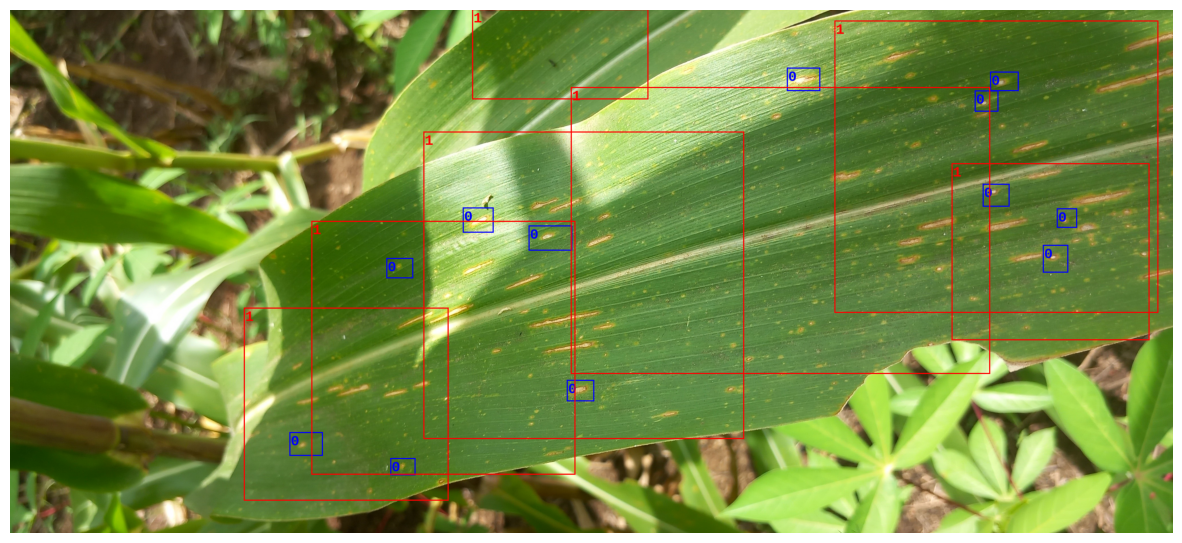

In [242]:
with torch.no_grad():
    preds = model([image_t])

# img_bbox_target = draw_bboxes(image, target)
# img_bbox_preds = draw_bboxes(image, preds[0], color="red")
# grid =  utils.make_grid([img_bbox_target, img_bbox_preds])

bbox_img = draw_bboxes(image, target)
bbox_img = draw_bboxes(bbox_img, preds[0], color="red")


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

### Comparing feature maps

In [273]:
model.detector.backbone(image_t.unsqueeze(0)).keys()

odict_keys(['0', '1', 'pool'])

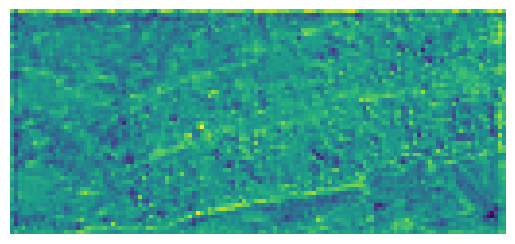

In [243]:
with torch.no_grad():
    fmap = model.detector.backbone(image_t.unsqueeze(0))
    
fmap = get_fmap_fpn_layer(fmap, "0")

# grid = utils.make_grid(fmap, normalize=False)


plt.figure()
plt.imshow(fmap.cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

## Checking region proposals

In [244]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform, resize_boxes
from collections import OrderedDict

In [245]:
max_size = np.max(image_t.shape[1:])
min_size = np.min(image_t.shape[1:])
# image_mean = [0.485, 0.456, 0.406]
# image_std = [0.229, 0.224, 0.225]
image_mean=[0.4763, 0.5514, 0.3163]
image_std=[0.2901, 0.2821, 0.2724]
grcnn_transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

In [246]:
images_rt, targets_rt = grcnn_transform([image_t], [target_t])

In [247]:
# temp = pd.read_csv("../submissions/submission_10.csv")
# temp["width"] = (temp["xmax"] - temp["xmin"])
# temp.sort_values("width").head(30)
features = model.detector.backbone(image_t.unsqueeze(0))
# features = features = OrderedDict([("0", features)])
proposals, proposal_losses = model.detector.rpn(images_rt, features, targets_rt)

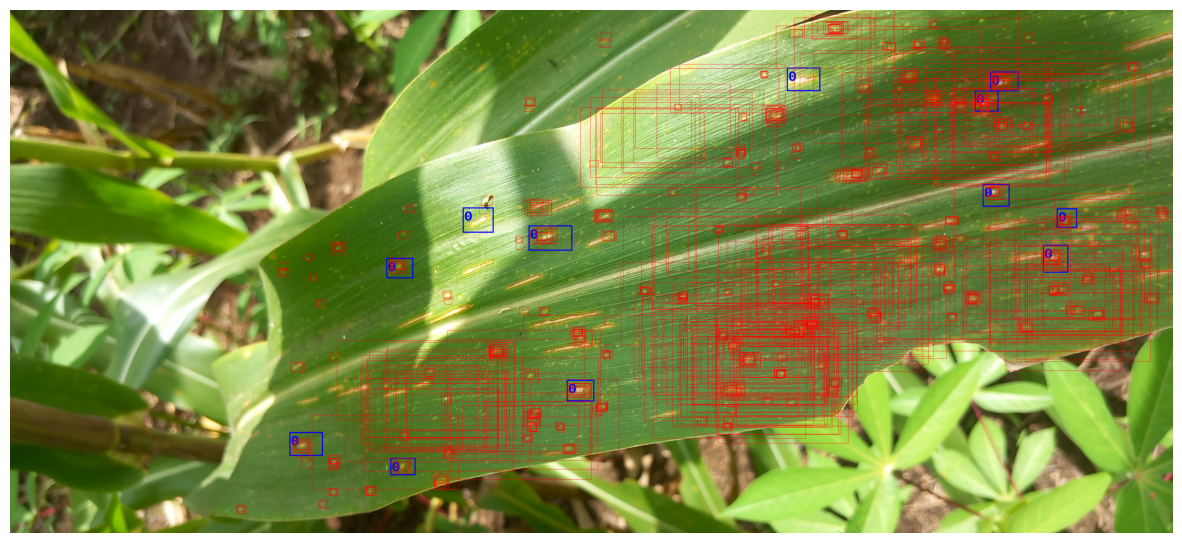

In [248]:
labels = torch.ones(len(proposals[0])) * -1

proposal_bbox_dict = {"boxes": proposals[0], "labels": labels}


bbox_img = draw_bboxes(image, targets_rt[0])
bbox_img = draw_bboxes(bbox_img, proposal_bbox_dict, color="red", width=1, font_size=1)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

In [249]:
model.detector.roi_heads(features, proposals, images_rt.image_sizes, targets_rt)

([{'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>),
   'labels': tensor([], dtype=torch.int64),
   'scores': tensor([], grad_fn=<IndexBackward0>)}],
 {})

In [258]:
import sys

detections = None
proposals = None

holder = {}
def trace_function(frame, event, arg):
    # Hook into the function's execution
    if event == "call":
        pass
    elif event == "return":
        pass
    elif event == "line":
        if "proposals" in frame.f_locals:
            holder["proposals"] = frame.f_locals["proposals"]
        if "detections" in frame.f_locals:
            # if "detections" in holder:
            holder["detections"] = frame.f_locals["detections"]
            # else: holder["detections"] = frame.f_locals["detections"]
        if "original_image_sizes" in frame.f_locals:
            holder["original_image_sizes"] = frame.f_locals["original_image_sizes"]
        if "images" in frame.f_locals:
            if hasattr(frame.f_locals["images"], "image_sizes"):
                holder["new_image_sizes"] = frame.f_locals["images"].image_sizes
    return trace_function

def inspect_during_execution(func, *args, **kwargs):
    # Set the trace function
    sys.settrace(trace_function)
    try:
        return func(*args, **kwargs)
    finally:
        # Ensure tracing is removed after function execution
        sys.settrace(None)


# Inspect the function without pausing
def get_detections_and_proposals():
    model.eval()
    with torch.no_grad():
        result = inspect_during_execution(model.detector.forward, [image_t])
    proposal_bboxes = resize_boxes(holder["proposals"][0], holder["new_image_sizes"][0], holder["original_image_sizes"][0])

    return result[0], {"boxes": proposal_bboxes, "labels":torch.ones(len(proposal_bboxes))*-1}

In [257]:
holder

{'original_image_sizes': [(1836, 4080)],
 'new_image_sizes': [(599, 1333)],
 'proposals': [tensor([[ 363.2163,  229.0948,  737.0250,  463.8367],
          [ 436.7802,  229.2267,  835.3950,  439.6705],
          [1113.1873,   82.1875, 1143.3242,  105.5463],
          ...,
          [1194.5408,  290.2971, 1221.9458,  313.3163],
          [ 750.8369,  125.9584, 1051.3162,  387.2630],
          [1137.5748,  351.9682, 1168.1305,  375.5710]])],
 'detections': [{'boxes': tensor([[1450.0527,  429.5458, 2575.2681, 1506.5662],
           [2892.4150,   40.2936, 4028.8728, 1064.9313],
           [1057.8137,  742.4302, 1983.4895, 1631.4313],
           [ 820.7421, 1046.5284, 1538.3904, 1722.1271],
           [1621.4740,    0.0000, 2239.7527,  316.5191],
           [1967.5883,  273.9681, 3438.9319, 1278.2816],
           [3303.5193,  540.9297, 3997.7810, 1160.8086]],
          grad_fn=<StackBackward0>),
   'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
   'scores': tensor([0.5010, 0.4310, 0.3769, 0.1813, 

In [263]:
detections, proposals = get_detections_and_proposals()
detections

{'boxes': tensor([[1450.0527,  429.5458, 2575.2681, 1506.5662],
         [2892.4150,   40.2936, 4028.8728, 1064.9313],
         [1057.8137,  742.4302, 1983.4895, 1631.4313],
         [ 820.7421, 1046.5284, 1538.3904, 1722.1271],
         [1621.4740,    0.0000, 2239.7527,  316.5191],
         [1967.5883,  273.9681, 3438.9319, 1278.2816],
         [3303.5193,  540.9297, 3997.7810, 1160.8086]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'scores': tensor([0.5010, 0.4310, 0.3769, 0.1813, 0.1254, 0.0657, 0.0576])}

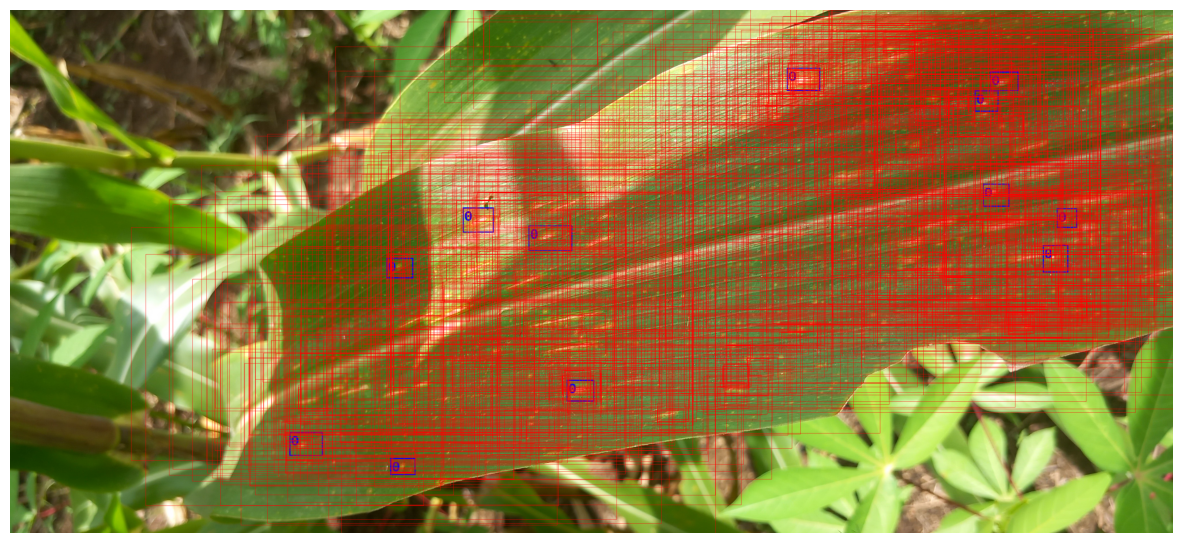

In [252]:
bbox_img = draw_bboxes(image, target_t)
bbox_img = draw_bboxes(bbox_img, proposals, color="red", width=1, font_size=1)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

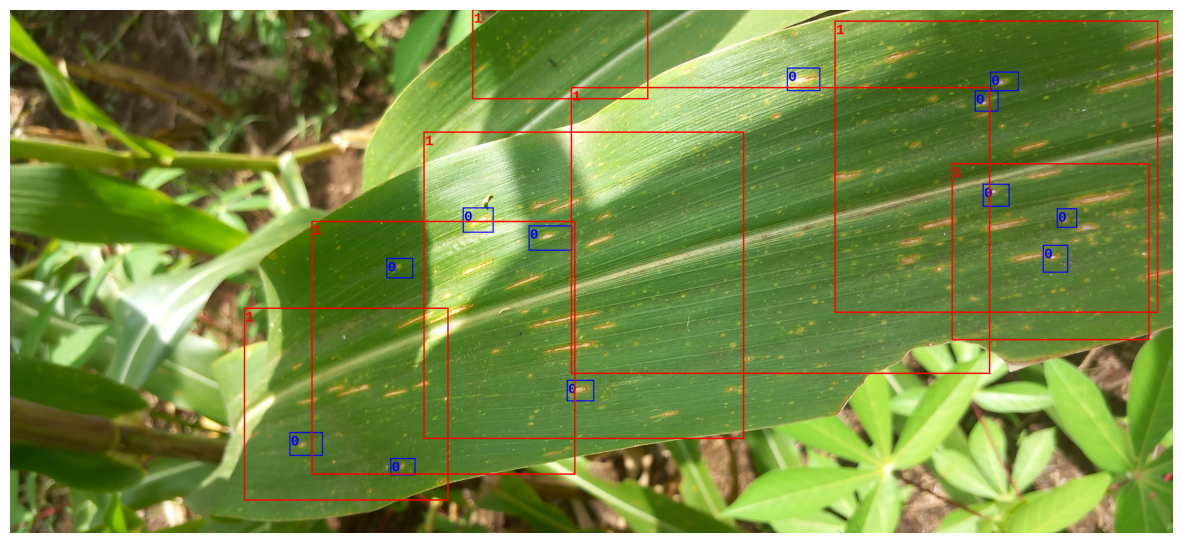

In [253]:
bbox_img = draw_bboxes(image, target_t)
bbox_img = draw_bboxes(bbox_img, detections, color="red", width=5, font_size=50)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()